In [1]:
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from q2_anomaly_detection.datasets import KeyboardDataset
from q2_anomaly_detection.transforms import Rarefaction, CLR, AsDense, UniFrac, RarefactionBIOM
from q2_anomaly_detection.benchmark import Benchmark, ColumnValueSplitter, ExternalScorer, Scorer
from q2_anomaly_detection.utils import as_dense, TrivialScorer
from q2_anomaly_detection.cross_validation import column_value_splitter
%matplotlib inline

In [2]:
RANDOM_SEED = 724
RAREFACTION_DEPTH = 500
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = KeyboardDataset('data/keyboard')

Files already downloaded and verified


In [38]:
TRAINING_CATEGORY = 'host_subject_id'
TRUTH_CATEGORY = 'host_subject_id'

In [39]:
def construct_category(metadata):
    metadata['host_subject_id_for_surface'] = np.nan
    skin_samples = metadata.index[metadata.sample_type == 'skin']
    metadata.loc[:, 'host_subject_id_for_surface'].loc[skin_samples] = metadata.host_subject_id[
        skin_samples].to_numpy()


def subset_metadata(metadata_all):
    subject_ids = ['M2','M3', 'M9']
    metadata = metadata_all.query('host_subject_id in @subject_ids')
    return metadata

In [40]:
table = dataset['table']

In [41]:
metadata_all = dataset['metadata']
metadata = subset_metadata(metadata_all)
metadata = metadata.set_index('sample_name')

In [42]:
construct_category(metadata)
table.filter(metadata.index, axis='sample')

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


2180 x 104 <class 'biom.table.Table'> with 12380 nonzero entries (5% dense)

In [43]:
np.random.seed(RANDOM_SEED)
subtable = table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [44]:
study_ids = subtable.ids('sample')

In [45]:
baseline = Pipeline(steps=[
    ('asdense', AsDense()),
    ('baseline', TrivialScorer()),
])
iso = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('IF', IsolationForest(contamination="auto")),
])
lof = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

iso_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('IF', IsolationForest(contamination="auto")),
])
lof_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'baseline': {
        'model': baseline,
    },
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
    'IF-clr': {
        'model': iso_clr,
    },
    'LOF-clr': {
        'model': lof_clr,
    },
    'LOF-jaccard-clr': {
        'model': lof_jaccard_clr,
    },
    'ocsvm-clr': {
        'model': ocsvm_clr,
    },
}

In [117]:
tree = tree_path = 'data/resources/97_otus.tree'
class PseudoTimeSplitter:
    def __init__(self, training_category, truth_category):
        self.training_category = training_category
        self.truth_category = truth_category
        self.dm_pipeline = Pipeline(
                [
                    ('rarefy', RarefactionBIOM(RAREFACTION_DEPTH)),
                    ('unifrac', UniFrac(tree_path)),
                ]
            )
        
    def split(self, table, metadata):
        """
        Yields
        ------
        label : str
            Name for the split
        training_table : BIOMTable
            Data for fitting detection model
        train_ids : set(str)
            A collection of train ids
        test_table : BIOMTable
            Data for testing
        test_labels : arrary like of shape (n_samples,)
            Values should be 0 or 1. 1 is anomaly and 0 is not
        """
        # returns generator
        col_val_split = column_value_splitter(
            table, metadata, self.training_category,
        )
        
        for label, ids, training_table in col_val_split:
            # testing
            # removing training samples from the table with all data
            sorted_ordination = self.get_sorted_ordination(training_table)
            sample_order = sorted_ordination.index.values
            sample_order = [int(i) for i in sample_order]
            sample_ids_ordered = training_table.ids("sample")[sample_order]
            
            training_table = training_table.sort_order(sample_ids_ordered)
            train_ids = set(sample_ids_ordered)
            test_labels = np.zeros(len(train_ids))
            test_labels[1] = 1
            yield label, training_table, train_ids, None, test_labels
            
    def get_sorted_ordination(self, table):
            dm = self.dm_pipeline.fit_transform(table)

            pcoa_results = pcoa(dm)
            print(pcoa_results.proportion_explained)
            ordination = pcoa_results.samples
            ordination = ordination.sort_values("PC1")
            return ordination
            
class PseudoTimeScorer(Scorer):
    
    def score_raw(self, context):
        model = context["model"]      
        return model.scores_
    
    def add_scores(self, results, context):
        train_ids = context["train_ids"]
        training_table = context["training_table"]
        anomaly_scores = []
        for id_, score, scaled, ranked_score in zip(
                    training_table.ids('sample'),
                    self.scores, self.scores_scaled, 
                    self.ranked_scores
                ):
            anomaly_scores.append(
                {
                    'sample_id': id_, 'score': score,
                    'scaled_score': scaled,
                    'score_rank': ranked_score,
                    'train_test': 'test',
                }
            )
        results["anomaly_scores"] =  anomaly_scores


class TimeSeriesPipeline(Pipeline):
    
    def set_score_model(self, model):
        self.score_model = model
    @property
    def scores_(self):
        return self.score_model.scores_
        
        
class MockTimeSeriesModel(LocalOutlierFactor):
    
    def fit(self, X, y=None):
        super().fit(X, y)
        self.scores_ = self.negative_outlier_factor_
        return self
        

In [136]:
splitter = PseudoTimeSplitter(TRAINING_CATEGORY, TRUTH_CATEGORY)
external_scorer = PseudoTimeScorer()
model = MockTimeSeriesModel(metric="euclidean", n_neighbors=5)
pipeline = TimeSeriesPipeline([
#             ("rarefy", RarefactionBIOM(RAREFACTION_DEPTH)),
            ("as_dense", AsDense()),
            ("clr", CLR()),
#             ("unifrac", UniFrac(tree_path)),
            ("lof", model)
        ])
pipeline.set_score_model(model)
models = {
    "mock": {
        "model": pipeline
    }
}
benchmark = Benchmark(models)
benchmark.set_scorer(external_scorer)
benchmark.set_splitter(splitter)
all_results = benchmark.benchmarking_loop(subtable, submetadata)

PC1     0.122850
PC2     0.097448
PC3     0.052665
PC4     0.049713
PC5     0.042833
PC6     0.038391
PC7     0.037211
PC8     0.035427
PC9     0.033569
PC10    0.031238
PC11    0.030658
PC12    0.028941
PC13    0.027098
PC14    0.026038
PC15    0.025543
PC16    0.023919
PC17    0.023169
PC18    0.022514
PC19    0.020773
PC20    0.020679
PC21    0.019228
PC22    0.017756
PC23    0.016053
PC24    0.015293
PC25    0.015076
PC26    0.013819
PC27    0.013328
PC28    0.013160
PC29    0.012310
PC30    0.011452
PC31    0.011039
PC32    0.010592
PC33    0.009724
PC34    0.009135
PC35    0.007799
PC36    0.007411
PC37    0.006147
PC38    0.000000
dtype: float64
PC1     0.079357
PC2     0.076008
PC3     0.061937
PC4     0.055304
PC5     0.051378
PC6     0.050460
PC7     0.047165
PC8     0.044254
PC9     0.042184
PC10    0.039779
PC11    0.037374
PC12    0.034131
PC13    0.031375
PC14    0.030975
PC15    0.029381
PC16    0.026955
PC17    0.026033
PC18    0.025236
PC19    0.023849
PC20    0.021607

In [137]:
normalized_score = all_results.long_form().reset_index()\
    .drop(["model_name", "category"], axis=1)\
    .set_index("sample_id")["scaled_score"].to_dict()

PC1     0.122850
PC2     0.097448
PC3     0.052665
PC4     0.049713
PC5     0.042833
PC6     0.038391
PC7     0.037211
PC8     0.035427
PC9     0.033569
PC10    0.031238
PC11    0.030658
PC12    0.028941
PC13    0.027098
PC14    0.026038
PC15    0.025543
PC16    0.023919
PC17    0.023169
PC18    0.022514
PC19    0.020773
PC20    0.020679
PC21    0.019228
PC22    0.017756
PC23    0.016053
PC24    0.015293
PC25    0.015076
PC26    0.013819
PC27    0.013328
PC28    0.013160
PC29    0.012310
PC30    0.011452
PC31    0.011039
PC32    0.010592
PC33    0.009724
PC34    0.009135
PC35    0.007799
PC36    0.007411
PC37    0.006147
PC38    0.000000
dtype: float64


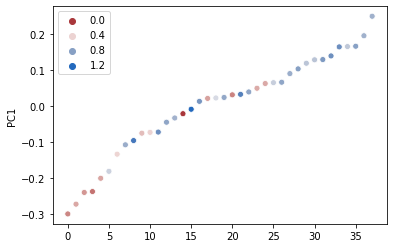

PC1     0.079357
PC2     0.076008
PC3     0.061937
PC4     0.055304
PC5     0.051378
PC6     0.050460
PC7     0.047165
PC8     0.044254
PC9     0.042184
PC10    0.039779
PC11    0.037374
PC12    0.034131
PC13    0.031375
PC14    0.030975
PC15    0.029381
PC16    0.026955
PC17    0.026033
PC18    0.025236
PC19    0.023849
PC20    0.021607
PC21    0.020317
PC22    0.019918
PC23    0.018673
PC24    0.016596
PC25    0.015504
PC26    0.015186
PC27    0.014484
PC28    0.013819
PC29    0.011535
PC30    0.010214
PC31    0.009008
PC32    0.000000
dtype: float64


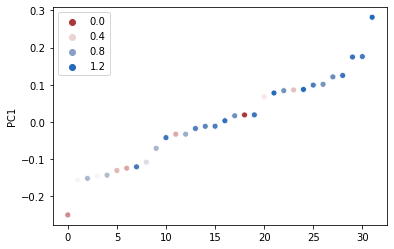

PC1     0.149701
PC2     0.110971
PC3     0.070816
PC4     0.065020
PC5     0.060998
PC6     0.053206
PC7     0.044980
PC8     0.040597
PC9     0.039026
PC10    0.037029
PC11    0.034116
PC12    0.031799
PC13    0.030825
PC14    0.029701
PC15    0.024256
PC16    0.023354
PC17    0.019788
PC18    0.018983
PC19    0.018389
PC20    0.017330
PC21    0.015095
PC22    0.013627
PC23    0.012761
PC24    0.011004
PC25    0.009194
PC26    0.007098
PC27    0.005648
PC28    0.004687
PC29    0.000000
dtype: float64


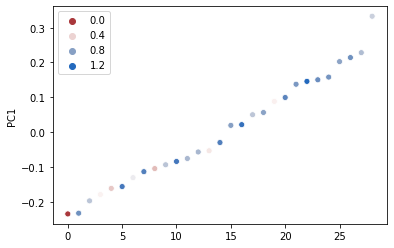

In [138]:
# returns generator
col_val_split = column_value_splitter(
    subtable, submetadata, TRAINING_CATEGORY,
)

for label, ids, training_table in col_val_split:
    ordination = splitter.get_sorted_ordination(training_table)
    sample_order = ordination.index.values
    sample_order = [int(i) for i in sample_order]
    sample_ids_ordered = training_table.ids("sample")[sample_order]
    id_to_subject = submetadata["host_subject_id"].to_dict()
    hue = [normalized_score[id_] for id_ in sample_ids_ordered]
    sns.scatterplot(x=np.arange(len(ordination)), y=ordination["PC1"],
                   hue=hue, palette="vlag_r")

    plt.show()